In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D,
                                     MaxPooling2D, LayerNormalization, MultiHeadAttention,
                                     DepthwiseConv2D, BatchNormalization, Add, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
import datetime
from sklearn.linear_model import LogisticRegression

# Paths and Parameters
root_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed/"
paths = [
    os.path.join(root_dir, "im_Dyskeratotic", "im_Dyskeratotic", "CROPPED"),
    os.path.join(root_dir, "im_Koilocytotic", "im_Koilocytotic", "CROPPED"),
    os.path.join(root_dir, "im_Metaplastic", "im_Metaplastic", "CROPPED"),
    os.path.join(root_dir, "im_Parabasal", "im_Parabasal", "CROPPED"),
    os.path.join(root_dir, "im_Superficial-Intermediate", "im_Superficial-Intermediate", "CROPPED")
]

height, width, channels = 64, 64, 3
num_classes = len(paths)


# Load images from folders
def load_images_from_paths(paths, img_size=(height, width)):
    images = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    for idx, p in enumerate(paths):
        if not os.path.exists(p):
            print(f"Warning: path not found {p}")
            continue
        for file in os.listdir(p):
            if not file.lower().endswith(valid_extensions):
                continue
            try:
                img_path = os.path.join(p, file)
                img = Image.open(img_path).convert('RGB').resize(img_size)
                img = np.array(img).astype(np.float32) / 255.0
                if img.shape != (height, width, channels):
                    continue
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Failed loading {file}: {e}")
                continue
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)


# Load data and labels
data, labels = load_images_from_paths(paths)

# One-hot labels for training neural net
labels_one_hot = tf.one_hot(labels, depth=num_classes).numpy()

# Train/val/test split
X_train, X_tmp, y_train, y_tmp = train_test_split(data, labels_one_hot, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=np.argmax(y_tmp, axis=1))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


# CoAtNet Components
def conv_bn(x, filters, kernel_size, strides, padding="same"):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def depthwise_conv_bn(x, kernel_size, strides, padding="same"):
    x = DepthwiseConv2D(kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def coatnet_block(x, filters, kernel_size=3, strides=1, num_heads=2, expansion=4):
    # Convolution branch
    conv = conv_bn(x, filters, kernel_size, strides)
    conv = conv_bn(conv, filters, kernel_size, strides)

    # Attention branch: giảm spatial dimension bằng pooling
    pooled = tf.keras.layers.AveragePooling2D(pool_size=4)(x)  # giảm 64x64 -> 16x16
    batch_size = tf.shape(pooled)[0]
    height = pooled.shape[1]
    width = pooled.shape[2]
    channels = pooled.shape[3]
    spatial_dim = height * width

    attn = Reshape((spatial_dim, channels))(pooled)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=channels)(attn, attn)
    attn = Dense(filters)(attn)
    attn = Reshape((height, width, filters))(attn)
    attn = tf.image.resize(attn, (x.shape[1], x.shape[2]))  # resize lại về kích thước gốc

    # Combine branches
    combined = Add()([conv, attn])
    return BatchNormalization()(combined)





# CoAtNet Model
def create_coatnet_model(input_shape=(height, width, channels), num_classes=num_classes):
    inputs = Input(shape=input_shape)

    # Initial convolution
    x = conv_bn(inputs, 32, 3, strides=1)

    # CoAtNet Blocks
    x = coatnet_block(x, 64, kernel_size=3, strides=1, num_heads=4)
    x = coatnet_block(x, 128, kernel_size=3, strides=1, num_heads=4)
    x = coatnet_block(x, 256, kernel_size=3, strides=1, num_heads=4)

    # Global pooling and classification
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model


# Build and compile the model
model = create_coatnet_model()

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_coatnet_model_V9.keras", monitor="val_accuracy", save_best_only=True, mode="max")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-7)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),  
    validation_data=(X_val, y_val),
    epochs=200,
    callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard_cb]
)

# Load best weights
model.load_weights("best_coatnet_model_V9.keras")

# Feature extractor model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

# Extract embeddings for train, val, and test sets
features_train = feature_extractor.predict(X_train)
features_val = feature_extractor.predict(X_val)
features_test = feature_extractor.predict(X_test)

# Convert one-hot labels to integer labels
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# Train Logistic Regression on extracted embeddings


# Initialize Logistic Regression model
log_reg = LogisticRegression(
    max_iter=400,       # Số vòng lặp tối đa
    random_state=42,    # Đảm bảo tái lập kết quả
    solver='saga',      # Bộ giải thích 
    multi_class='multinomial'  # Xử lý phân loại nhiều lớp
)

# Train Logistic Regression
log_reg.fit(features_train, y_train_int)

# Evaluate Logistic Regression on validation set
y_val_pred = log_reg.predict(features_val)
print("Validation Accuracy (Logistic Regression):", accuracy_score(y_val_int, y_val_pred))
print("Classification Report (Validation Set):\n", classification_report(y_val_int, y_val_pred))

# Evaluate Logistic Regression on test set
y_test_pred = log_reg.predict(features_test)
print("Test Accuracy (Logistic Regression):", accuracy_score(y_test_int, y_test_pred))
print("Classification Report (Test Set):\n", classification_report(y_test_int, y_test_pred))


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/200
45/45 [==============================] - 37s 483ms/step - loss: 1.2468 - accuracy: 0.5233 - val_loss: 4.9446 - val_accuracy: 0.2471
Epoch 2/200
45/45 [==============================] - 17s 366ms/step - loss: 0.8171 - accuracy: 0.6983 - val_loss: 2.5424 - val_accuracy: 0.3245
Epoch 3/200
45/45 [==============================] - 17s 375ms/step - loss: 0.6797 - accuracy: 0.7594 - val_loss: 2.2905 - val_accuracy: 0.2867
Epoch 4/200
45/45 [==============================] - 18s 393ms/step - loss: 0.5977 - accuracy: 0.7897 - val_loss: 2.8374 - val_accuracy: 0.2389
Epoch 5/200
45/45 [==============================] - 18s 407ms/step - loss: 0.5449 - accuracy: 0.8063 - val_loss: 2.7241 - val_accuracy: 0.2603
Epoch 6/200
45/45 [==============================] - 19s 428ms/step - loss: 0.5023 - accuracy: 0.8190 - val_loss: 2.0159 - val_accuracy: 0.4102
Epoch 7/200
45/45 [==============================] - 20s 455ms/step - loss: 0.4749 - accuracy: 0.8306 - val_loss: 1.4935 - val_accuracy:

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


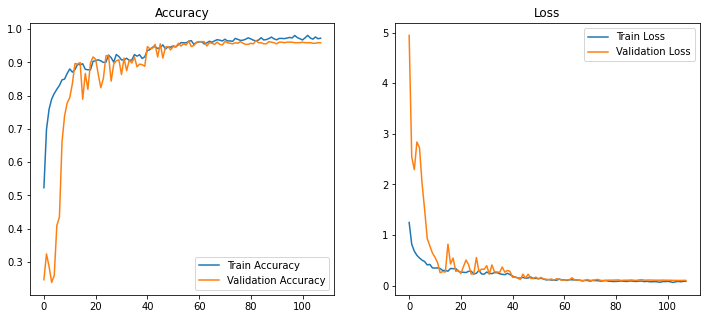

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression

# --- Visualize Training History ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


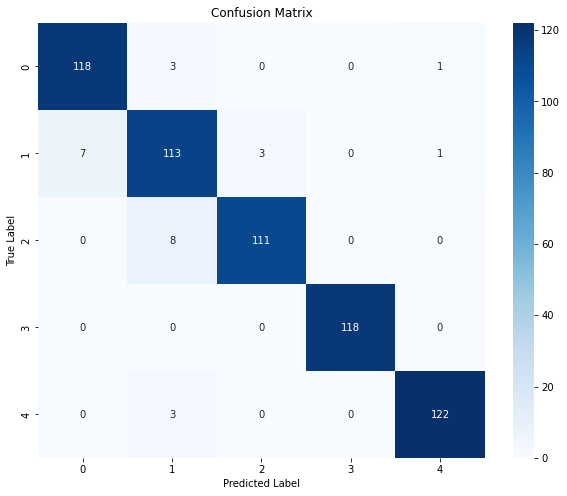

In [5]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test_int, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(len(np.unique(y_test_int))),
            yticklabels=range(len(np.unique(y_test_int))))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


10 Test Predictions vs Actual Labels:
Sample 1: Predicted = 3, Actual = 3
Sample 2: Predicted = 1, Actual = 1
Sample 3: Predicted = 0, Actual = 0
Sample 4: Predicted = 3, Actual = 3
Sample 5: Predicted = 3, Actual = 3
Sample 6: Predicted = 2, Actual = 2
Sample 7: Predicted = 0, Actual = 0
Sample 8: Predicted = 4, Actual = 4
Sample 9: Predicted = 4, Actual = 4
Sample 10: Predicted = 0, Actual = 0


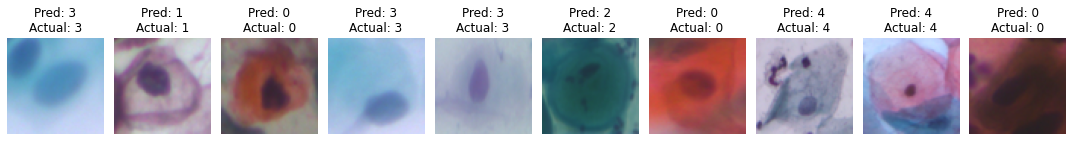

In [6]:
# --- Display Test Predictions vs Actual Labels ---
print("10 Test Predictions vs Actual Labels:")
for i in range(10):
    print(f"Sample {i+1}: Predicted = {y_test_pred[i]}, Actual = {y_test_int[i]}")

# --- Display Images with Predictions ---
def display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.title(f"Pred: {y_test_pred[i]}\nActual: {y_test_int[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10)

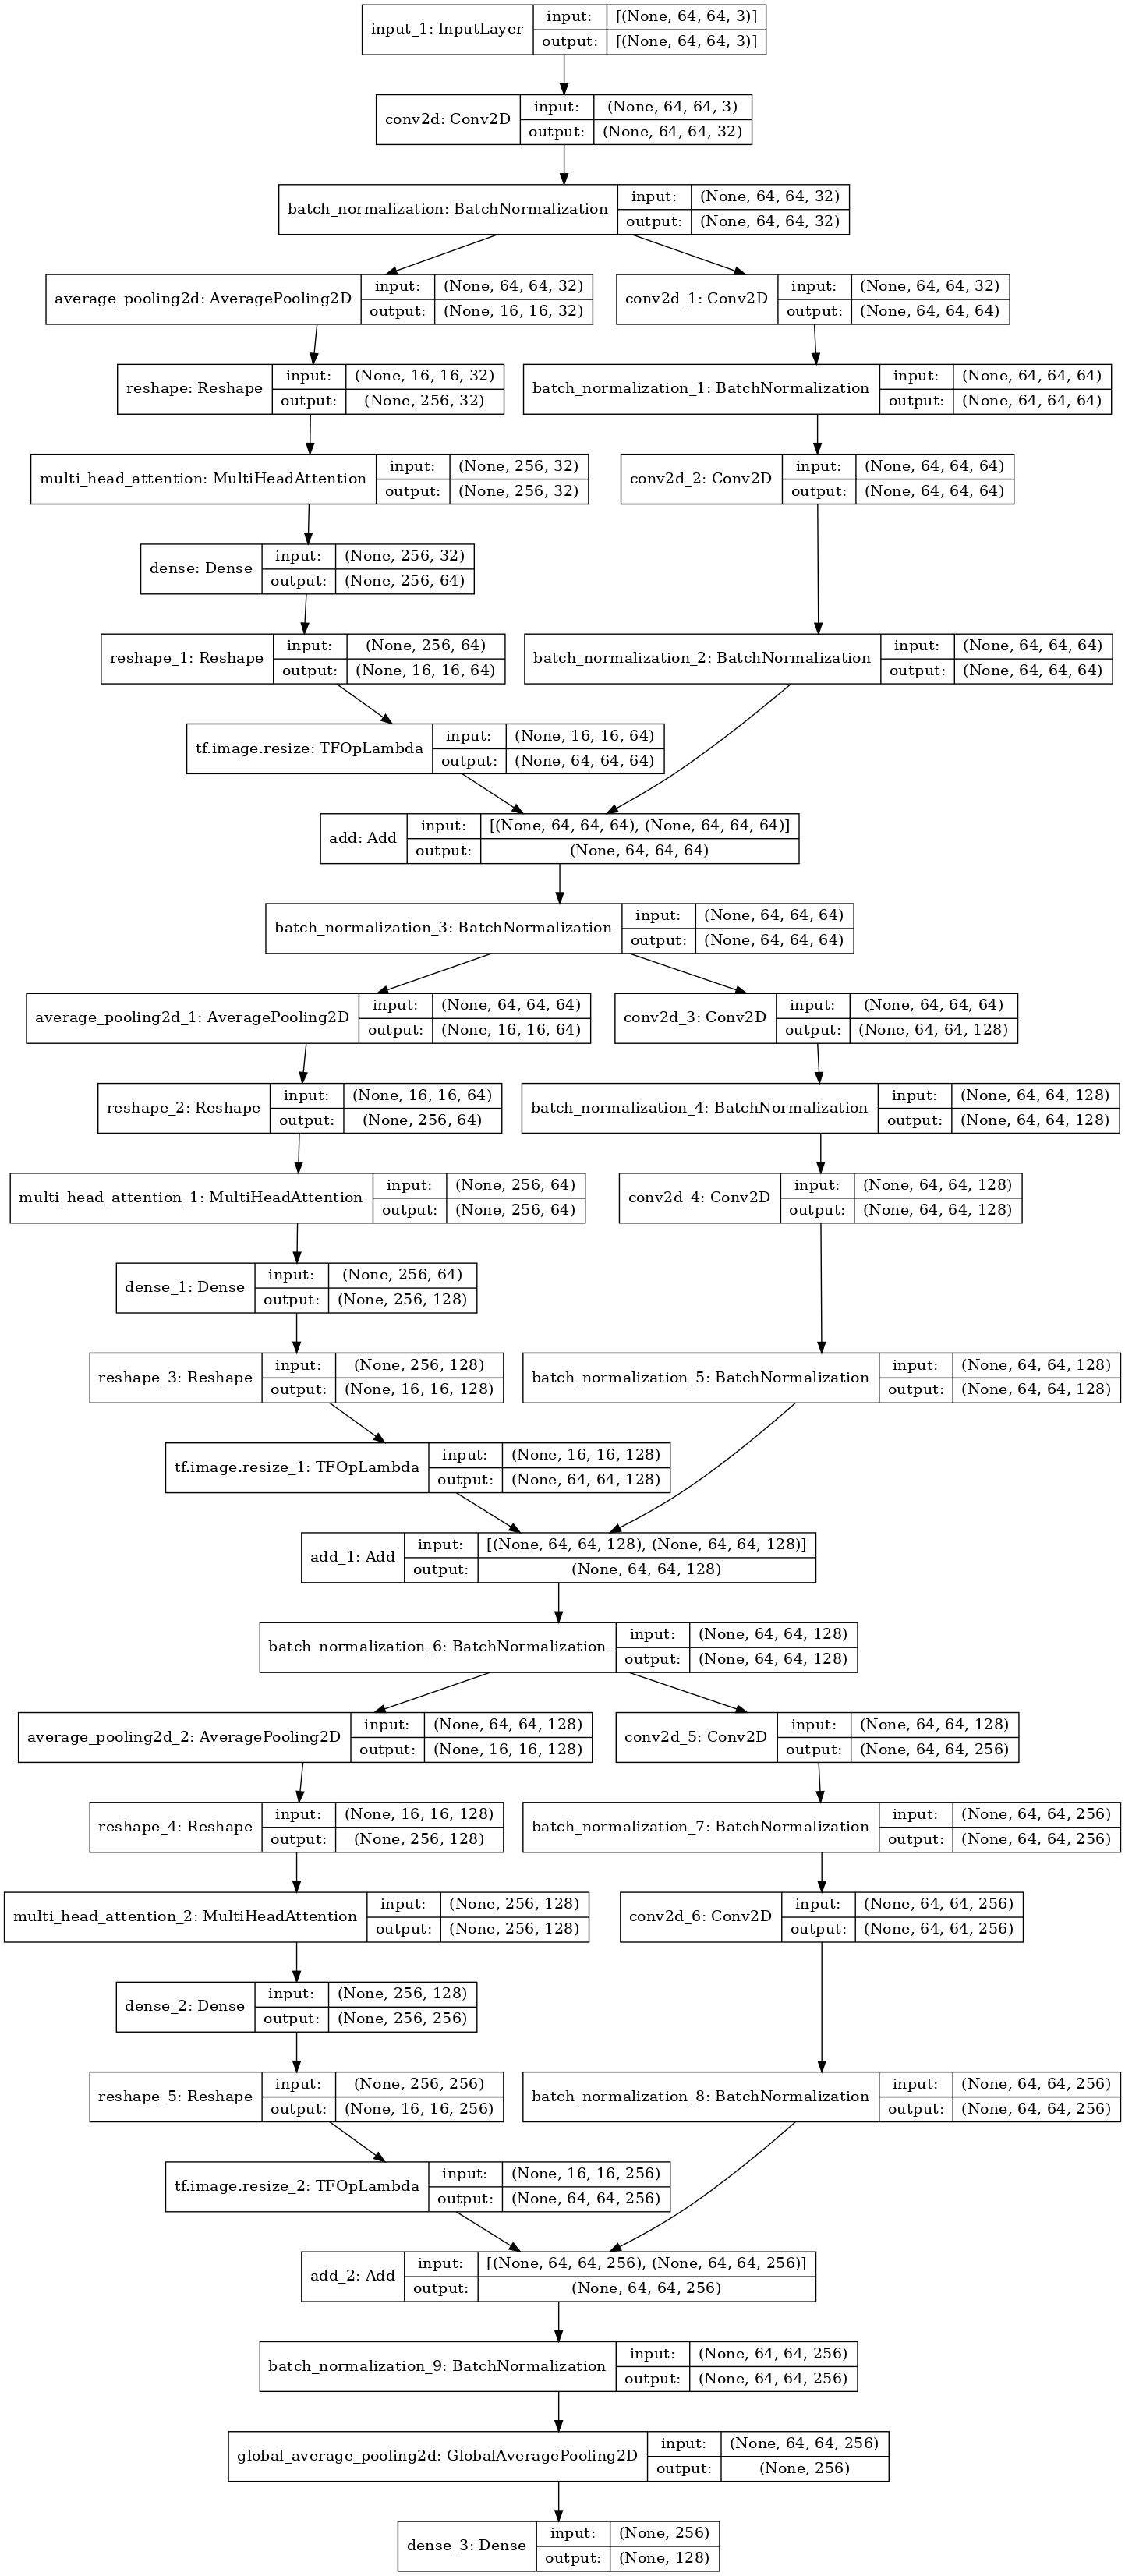

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(feature_extractor, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=100)